# Data Mining Assignment Parts 1 and 2
Vyron-Georgios Anemogiannis 1115202000008  \
Georgios-Alexandros Vasilakopoulos 1115202000018

Assignment Written Locally

In [1]:
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
import wordcloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from math import ceil

[nltk_data] Downloading package stopwords to /home/byron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Getting the data

In [2]:
df = pd.read_csv('books_1.Best_Books_Ever.csv')


### Removing the rows without a description, or non english. Other rows don't need to be removed since they are not needed

In [3]:
# I care only about English books that have a description (For the recommendation system)
print(len(df))

df = df[df['language'] == 'English']
df = df[df['description'].notna()]

print(len(df))


52478
42151


# Preprocessing

In [4]:
def convert_to_list(row):
    return eval(row)

df['ratingsByStars'] = df['ratingsByStars'].apply(convert_to_list)


df['1_star'] = df['ratingsByStars'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
df['2_star'] = df['ratingsByStars'].apply(lambda x: x[1] if len(x) > 1 else np.nan)
df['3_star'] = df['ratingsByStars'].apply(lambda x: x[2] if len(x) > 2 else np.nan)
df['4_star'] = df['ratingsByStars'].apply(lambda x: x[3] if len(x) > 3 else np.nan)
df['5_star'] = df['ratingsByStars'].apply(lambda x: x[4] if len(x) > 4 else np.nan)

df['1_star'] 
    

0        3444695
1        1593642
2        2363896
3        1617567
4        1751460
          ...   
52473        311
52474         16
52475       2109
52476         77
52477        106
Name: 1_star, Length: 42151, dtype: object

In [5]:
df['genres'] = df['genres'].apply(convert_to_list)
df['genreSingle'] = df['genres'].apply(lambda x: x[0] if len(x) > 0 else np.nan)

df['genreSingle']

0        Young Adult
1            Fantasy
2           Classics
3           Classics
4        Young Adult
            ...     
52473       Vampires
52474        Mystery
52475        Fantasy
52476        Fiction
52477    Lds Fiction
Name: genreSingle, Length: 42151, dtype: object

In [6]:

df['publishYear'] = pd.to_datetime(df['publishDate'], errors='coerce').dt.year.astype('Int64')

print(df['publishYear'])

0        2008
1        2004
2        2006
3        2000
4        2006
         ... 
52473    2011
52474    2011
52475    2011
52476    2011
52477    2011
Name: publishYear, Length: 42151, dtype: Int64


# Questions on data

## Question 1

<AxesSubplot: >

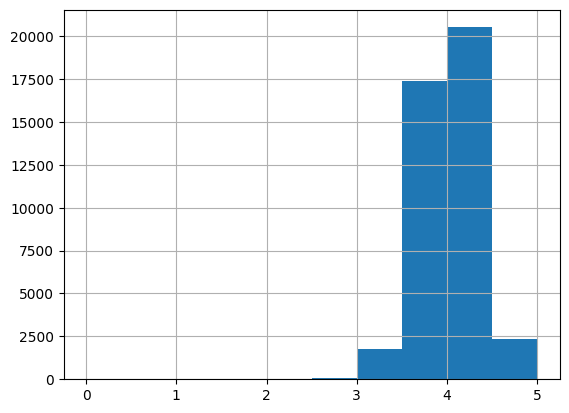

In [7]:
df['rating'].hist()

## Question 2

In [8]:
df['pages'] = pd.to_numeric(df['pages'], errors='coerce').astype('Int64')

Q2 = df.sort_values(by=['pages'], ascending=False).head(10)
Q2 = Q2[['title', 'pages']]
Q2

,title,pages
11490,The Story of Civilization,14777
22960,The Complete Wheel of Time,11095
8374,The Complete Malazan Book of the Fallen,8258
5098,Animorphs,8245
20098,Homestuck,8124
3148,Worm,6680
4692,The Complete Aubrey/Maturin Novels (5 Volumes),6576
1679,A Song of Ice and Fire,5216
38814,One Piece Box Set 3: Thriller Bark to New Worl...,5056
38247,One Piece Box Set 2: Skypeia and Water Seven: ...,4936


## Question 3

In [9]:
df['5_star'] = pd.to_numeric(df['5_star'], errors='coerce').astype('Int64')

Q3 = df[df['5_star'] > 10000]
Q3 = Q3.sort_values(by=['5_star'], ascending=False).head(10)
Q3 = Q3[['title', '5_star']]
Q3

,title,5_star
4,Twilight,548674
192,Fifty Shades of Grey,228885
40,The Catcher in the Rye,139016
1201,New Moon,121711
22,Lord of the Flies,120835
32,Harry Potter and the Sorcerer's Stone,118525
1116,Breaking Dawn,117129
158,"Eat, Pray, Love",112573
27,The Great Gatsby,112144
24,The Alchemist,102377


## Question 5

In [10]:
Q4 = df.groupby('author')['title'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
Q4

,author,count
15876,Nora Roberts (Goodreads Author),85
259,Agatha Christie,69
19605,Stephen King (Goodreads Author),62
2040,Bella Forrest (Goodreads Author),49
14488,Meg Cabot (Goodreads Author),49
6161,Erin Hunter,49
11304,Karen Kingsbury (Goodreads Author),48
20365,Terry Pratchett,48
14640,Mercedes Lackey,45
6024,Enid Blyton,43


## Question 6

In [11]:

df['numRatings'] = pd.to_numeric(df['numRatings'], errors='coerce').astype('Int64')

Q5 = df.groupby('author')['numRatings'].sum().reset_index(name='sum').sort_values(['sum'], ascending=False).head(10)
Q5

,author,sum
8544,"J.K. Rowling, Mary GrandPré (Illustrator)",17790643
19974,Suzanne Collins,11654607
19654,Stephenie Meyer,10710870
19605,Stephen King (Goodreads Author),10025253
17597,Rick Riordan (Goodreads Author),8111644
4237,Dan Brown (Goodreads Author),7014203
8609,J.R.R. Tolkien,6620587
8542,J.K. Rowling,6462880
10345,John Green (Goodreads Author),6355092
3119,Cassandra Clare (Goodreads Author),5637877


# Recomendation System

In [12]:
df = df[['bookId', 'description']]

df

,bookId,description
0,2767052-the-hunger-games,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,There is a door at the end of a silent corrido...
2,2657.To_Kill_a_Mockingbird,The unforgettable novel of a childhood in a sl...
3,1885.Pride_and_Prejudice,Alternate cover edition of ISBN 9780679783268S...
4,41865.Twilight,About three things I was absolutely positive.\...
...,...,...
52473,11492014-fractured,The Fateful Trilogy continues with Fractured. ...
52474,11836711-anasazi,"'Anasazi', sequel to 'The Thirteenth Chime' by..."
52475,10815662-marked,--READERS FAVORITE AWARDS WINNER 2011--Sixteen...
52476,11330278-wayward-son,A POWERFUL TREMOR UNEARTHS AN ANCIENT SECRETBu...


In [13]:
df['description'] = [r.lower() for r in df['description'] ]   #making everything lowercase
df['description'] = df['description'].apply(lambda r: re.sub(r'[^a-z]', ' ', r))   #only keeping letters


### Removing Stopwords

In [14]:
df['description'] = df['description'].apply(lambda r: ' '.join([word for word in r.split() if word not in (stop_words)]))


### Stemming

In [15]:
stemmer = PorterStemmer()
def stemming(text):
  tokens = text.split()
  ret = []
  for token in tokens:
    ret.append(stemmer.stem(token))
  return ' '.join(ret)

df['description'] = df['description'].apply(stemming)

### Lemmatization

In [16]:
lemmatizer = WordNetLemmatizer()
def lemmatization(text):
  tokens = text.split()
  ret = []
  for token in tokens:
    ret.append(lemmatizer.lemmatize(token))
  return ' '.join(ret)

df['description'] = df['description'].apply(lemmatization)

In [ ]:
df.to_csv('books_1.Best_Books_Ever_cleaned.csv', index=False)

In [2]:
df = pd.read_csv('books_1.Best_Books_Ever_cleaned.csv')
df = df[df['description'].notna()]
df = df.reset_index(drop=True)


### Vectorization 

In [3]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=1, norm='l1', stop_words=stop_words)
unigrams = vectorizer.fit_transform(df['description'])

vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_df=1.0, min_df=1, norm='l1', stop_words=stop_words)
bigrams = vectorizer.fit_transform(df['description'])

## Cosine Similarity

Impossible due to ram limitations to keep 100 recommendations in the dictionary, I keep up to 9, If you want more, check out the better approach provided bellow

### Unigrams

In [ ]:

recommendations = {}
for i in range(0, len(df)):
    if i % 1000 == 0:
        print(i)
        
    cosine_similarities = cosine_similarity(unigrams[i:i+1], unigrams[0:len(df)])
   
    recommendations[df['bookId'][i]] = cosine_similarities[0].argsort()[:-11:-1]


with open('recommendations.pickle', 'wb') as handle:
    pickle.dump(recommendations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
with open('recommendations.pickle', 'rb') as handle:
    recommendations = pickle.load(handle)

In [45]:
def recommend(item_id, num):

	print('Recommnending ' + str(num) + ' books similar to ' + str(item_id))
	

	print('---------------------------------------------------------')
	recs = recommendations[item_id][1:num+1]
	index = df[df['bookId'] == item_id].index[0]

	for rec in recs:
		print('Recommended: ' + str(df['bookId'][rec]))
		print('Description: ' + str(df['description'][rec]))
		print('(score: ' + str(cosine_similarity(unigrams[index], unigrams[rec])) + ')')

		print()
	


recommend(item_id = '2.Harry_Potter_and_the_Order_of_the_Phoenix', num = 5)


Recommnending 5 books similar to 2.Harry_Potter_and_the_Order_of_the_Phoenix
---------------------------------------------------------
Recommended: 15881.Harry_Potter_and_the_Chamber_of_Secrets
Description: ever sinc harri potter come home summer dursley mean hideou harri want get back hogwart school witchcraft wizardri pack bag harri receiv warn strang impish creatur say harri return hogwart disast strike strike harri second year hogwart fresh torment horror aris includ outrag stuck new professor spirit haunt girl bathroom real troubl begin someon turn hogwart student stone could draco malfoy poison rival ever could possibl hagrid whose mysteri past final told could one everyon hogwart suspect harri potter
(score: [[0.37030114]])

Recommended: 5.Harry_Potter_and_the_Prisoner_of_Azkaban
Description: harri potter third year hogwart full new danger convict murder siriu black broken azkaban prison seem harri hogwart patrol dementor azkaban guard hunt siriu harri imagin siriu matter evil l

### Bigrams

In [ ]:
recommendations = {}

for i in range(0, ceil(len(df)/2)):
    if i % 1000 == 0:
        print(i)
        
    cosine_similarities = cosine_similarity(bigrams[i:i+1], bigrams[0:len(df)])
  
    recommendations[df['bookId'][i]] = cosine_similarities[0].argsort()[:-11:-1]

with open('recommendationsB.pickle', 'wb') as handle:
    pickle.dump(recommendations, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
recommendations = {}
for i in range(ceil(len(df)/2), len(df)):
    if i % 1000 == 0:
        print(i)
        
    cosine_similarities = cosine_similarity(bigrams[i:i+1], bigrams[0:len(df)])
  
    recommendations[df['bookId'][i]] = cosine_similarities[0].argsort()[:-11:-1]

with open('recommendationsC.pickle', 'wb') as handle:
    pickle.dump(recommendations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('recommendationsB.pickle', 'rb') as handle:
    recommendations1 = pickle.load(handle)

with open('recommendationsC.pickle', 'rb') as handle:
    recommendations2 = pickle.load(handle)


recommendations = {**recommendations1, **recommendations2}

In [8]:
def recommend(item_id, num):

	print('Recommnending ' + str(num) + ' books similar to ' + str(item_id))
	

	print('---------------------------------------------------------')
	recs = recommendations[item_id][1:num+1]
	index = df[df['bookId'] == item_id].index[0]

	for rec in recs:
		print('Recommended: ' + str(df['bookId'][rec]))
		print('Description: ' + str(df['description'][rec]))
		print('(score: ' + str(cosine_similarity(bigrams[index], bigrams[rec])) + ')')

		print()
	


recommend(item_id = '2.Harry_Potter_and_the_Order_of_the_Phoenix', num = 5)

Recommnending 5 books similar to 2.Harry_Potter_and_the_Order_of_the_Phoenix
---------------------------------------------------------
Recommended: 5.Harry_Potter_and_the_Prisoner_of_Azkaban
Description: harri potter third year hogwart full new danger convict murder siriu black broken azkaban prison seem harri hogwart patrol dementor azkaban guard hunt siriu harri imagin siriu matter evil lord voldemort could frighten dementor terribl power fill anyon come across ach loneli despair meanwhil life continu usual hogwart top line broom take harri success quidditch sport wizard world new height cute fourth year student catch eye becom close new defens dark art teacher childhood friend father yet despit rel safeti life hogwart best effort dementor threat siriu black grow ever closer harri learn anyth educ wizardri thing often seem tragic revel heartwarm surpris high stake magic adventur await boy wizard funni poignant third instal belov seri scholast com
(score: [[0.03836546]])

Recommended:

Way more time to compute, way more ram needed, worse resaults

## Better approach

In [4]:
def recommend(ngrams, item, num):
	print('Recommnending ' + str(num) + ' books similar to ' + str(item))
	print('---------------------------------------------------------')
	index = df[df['bookId'] == item].index[0]
	cosine_similarities = cosine_similarity(ngrams[index], ngrams[0:len(df)])
	recs = cosine_similarities[0].argsort()[:-num:-1]
	for rec in recs[1:]:
		print('Recommended: ' + str(df['bookId'][rec]))
		print('Description: ' + str(df['description'][rec]))
		print('(score: ' + str(cosine_similarities[0][rec]) + ')')

		print()



In [5]:
recommend(ngrams = unigrams, item = '2.Harry_Potter_and_the_Order_of_the_Phoenix', num = 100)

Recommnending 100 books similar to 2.Harry_Potter_and_the_Order_of_the_Phoenix
---------------------------------------------------------
Recommended: 15881.Harry_Potter_and_the_Chamber_of_Secrets
Description: ever sinc harri potter come home summer dursley mean hideou harri want get back hogwart school witchcraft wizardri pack bag harri receiv warn strang impish creatur say harri return hogwart disast strike strike harri second year hogwart fresh torment horror aris includ outrag stuck new professor spirit haunt girl bathroom real troubl begin someon turn hogwart student stone could draco malfoy poison rival ever could possibl hagrid whose mysteri past final told could one everyon hogwart suspect harri potter
(score: 0.3703011412338946)

Recommended: 5.Harry_Potter_and_the_Prisoner_of_Azkaban
Description: harri potter third year hogwart full new danger convict murder siriu black broken azkaban prison seem harri hogwart patrol dementor azkaban guard hunt siriu harri imagin siriu matter 

array([    1,   126,    93,    32, 10105,   103,  6661, 41512,   105,
         944, 28224,  1539,  2657, 18875,  3202, 32759, 33921,  6520,
        1282,  2464,  9693,  2912, 12771,  7670,  3712,  2534, 27562,
        1290,  2650, 25766, 34945,  6159,  2187,  2077,  8824,  9513,
       35208, 37090, 35699, 32745, 41046,  2279,  4884,  7432, 12107,
       39807, 33111, 10728, 14617,  3367, 30915, 28132, 25735,  4422,
        4204, 17333,  6881,  1150, 35631,  7898, 36421, 20091, 13428,
        1832, 35147, 31743,  2486, 16725,   402,  8232,  7583, 33578,
       28778, 12403,  4232, 25881,  7419,  4596, 40651, 12988, 40552,
        4091,  5711,  2398, 11494, 28524, 41857, 36992, 10683, 36493,
          71, 19194, 31245, 21921, 34482, 16350, 39529,  3304, 36528])

In [6]:

recommend(ngrams = bigrams, item = '2.Harry_Potter_and_the_Order_of_the_Phoenix', num = 100)

Recommnending 100 books similar to 2.Harry_Potter_and_the_Order_of_the_Phoenix
---------------------------------------------------------
Recommended: 5.Harry_Potter_and_the_Prisoner_of_Azkaban
Description: harri potter third year hogwart full new danger convict murder siriu black broken azkaban prison seem harri hogwart patrol dementor azkaban guard hunt siriu harri imagin siriu matter evil lord voldemort could frighten dementor terribl power fill anyon come across ach loneli despair meanwhil life continu usual hogwart top line broom take harri success quidditch sport wizard world new height cute fourth year student catch eye becom close new defens dark art teacher childhood friend father yet despit rel safeti life hogwart best effort dementor threat siriu black grow ever closer harri learn anyth educ wizardri thing often seem tragic revel heartwarm surpris high stake magic adventur await boy wizard funni poignant third instal belov seri scholast com
(score: 0.03836545574202778)

Recom

array([    1,    93, 16503, 36211,  2745, 31178, 37854, 26781,  7544,
       13296,  8398, 22060, 41576,  1760, 11601, 12767, 29306, 28956,
        2187,  8685, 38839, 34947, 33578,  6674, 19592, 27925, 40917,
        1790, 16461, 36442, 25605, 39970, 22883, 16248, 32535, 33111,
       19196,  9883, 12522, 29674,  2912, 39467, 39648, 18378,  9046,
       11832,   126, 17887, 22753, 11479, 22479, 26254, 34590, 15109,
        9355, 30274, 10382, 33890, 11182, 10315, 28210, 33571, 24352,
       15751, 15190,  8710, 35551,  3258, 24773, 17571, 14075, 26857,
        6216, 35815, 40211,  7661, 22743, 26653,  2322,  5500, 15949,
       25599, 20860,    32, 16569,  2226, 10979, 29058, 10224,  9997,
       20637, 12274,  4691,  8527, 19232, 13150,   400, 14445,  4204])